In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob # For finding files matching a pattern
import os   # For joining path components
from scipy.stats import pearsonr, spearmanr # For correlation
from sklearn.metrics import jaccard_score # For Jaccard Index (requires binary vectors)

In [8]:
DATA_DIR = '/projects/prjs1491/Attention-based-RL-MIL/runs/classification/seed_0/oulad_aggregated_subset/instances/tabular/label/bag_size_20/MeanMLP_22_16_22/neg_policy_only_loss_attention_ilse_reg_sum_sample_static' 
FILE_PATTERN = 'neg_policy_only_loss_attention_ilse_reg_sum_sample_static_attention_ilse_outputs.csv' 
initial_file_path = os.path.join(DATA_DIR, FILE_PATTERN)

print(f"Libraries imported.")
print(f"Data directory set to: {os.path.abspath(DATA_DIR)}")
print(f"Initial file path set to: {initial_file_path}")

Libraries imported.
Data directory set to: /projects/prjs1491/Attention-based-RL-MIL/runs/classification/seed_0/oulad_aggregated_subset/instances/tabular/label/bag_size_20/MeanMLP_22_16_22/neg_policy_only_loss_attention_ilse_reg_sum_sample_static
Initial file path set to: /projects/prjs1491/Attention-based-RL-MIL/runs/classification/seed_0/oulad_aggregated_subset/instances/tabular/label/bag_size_20/MeanMLP_22_16_22/neg_policy_only_loss_attention_ilse_reg_sum_sample_static/neg_policy_only_loss_attention_ilse_reg_sum_sample_static_attention_ilse_outputs.csv


In [9]:
# --- Helper Function for Parsing Instance Content ---
def parse_instance_content(content_str):
    """
    Parses the string representation of instance content into a list of floats.
    Example input: "[6. 0. 0. ... 0.]"
    Handles potential extra spaces and converts to float.
    """
    if pd.isna(content_str):
        # Return an empty list if the content is NaN (missing)
        return [] 
    try:
        # Remove brackets, strip leading/trailing whitespace
        content_str = content_str.replace('[', '').replace(']', '').strip()
        # Split by space (handles multiple spaces as well) and convert to float
        # Filter out empty strings that might result from multiple spaces
        content_parts = [float(x) for x in content_str.split() if x]
        return content_parts
    except Exception as e:
        # Print an error message if parsing fails for any reason
        # print(f"Error parsing content: '{content_str}' -> {e}") 
        return [] # Return an empty list or another indicator of parsing failure

# --- Function to Load and Preprocess a Single CSV File ---
def load_and_preprocess_data(file_path, file_run_id=None):
    """
    Loads a single CSV file, performs initial preprocessing:
    - Derives run_id if not present.
    - Filters out padding instances.
    - Parses 'original_instance_content' into numerical lists.
    - Ensures 'attention_score' is numeric.
    """
    print(f"Processing file: {file_path}...")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return pd.DataFrame() # Return empty DataFrame if file not found
    except Exception as e:
        print(f"Error loading CSV {file_path}: {e}")
        return pd.DataFrame()

    # --- Ensure 'run_id' is present ---
    # If a file_run_id is provided (e.g. from filename when loading multiple files), use it.
    # Otherwise, check if 'run_id' column exists. If not, create a placeholder.
    if file_run_id:
        df['run_id'] = file_run_id
        print(f"  Assigned 'run_id': {file_run_id} to this DataFrame.")
    elif 'run_id' not in df.columns:
        # Basic placeholder if no run_id is found or provided
        # For a single file, its name (without extension) can be a sensible default
        derived_run_id = os.path.splitext(os.path.basename(file_path))[0]
        df['run_id'] = derived_run_id
        print(f"  'run_id' column not found. Derived 'run_id': {derived_run_id} from filename.")
    else:
        # If run_id column exists, ensure it's treated as string if it's not already
        df['run_id'] = df['run_id'].astype(str)
        print(f"  'run_id' column found. Unique run_ids in this file: {df['run_id'].unique()}")


    # --- 1. Filter out padding instances ---
    # Ensure 'is_padding_instance' column exists
    if 'is_padding_instance' not in df.columns:
        print("  Error: 'is_padding_instance' column not found. Cannot filter padding.")
        # Depending on your data, you might decide to proceed or return an empty/original df
        return pd.DataFrame() 
    
    df_non_padding = df[~df['is_padding_instance']].copy() # Use .copy() to avoid SettingWithCopyWarning
    print(f"  Original number of instances in file: {len(df)}")
    print(f"  Number of non-padding instances: {len(df_non_padding)}")

    if df_non_padding.empty:
        print("  No non-padding instances found after filtering.")
        return df_non_padding

    # --- 2. Parse 'original_instance_content' ---
    if 'original_instance_content' in df_non_padding.columns:
        df_non_padding.loc[:, 'parsed_instance_content'] = df_non_padding['original_instance_content'].apply(parse_instance_content)
        
        # Verification of parsing
        empty_parsed_count = df_non_padding['parsed_instance_content'].apply(lambda x: len(x) == 0).sum()
        original_nan_count = df_non_padding['original_instance_content'].isna().sum()
        print(f"  Instances with empty parsed_instance_content: {empty_parsed_count} (originally {original_nan_count} NaNs in content column).")
    else:
        print("  Warning: 'original_instance_content' column not found. Skipping parsing of instance content.")
        # Create an empty list for 'parsed_instance_content' if the original column is missing
        df_non_padding.loc[:, 'parsed_instance_content'] = [[] for _ in range(len(df_non_padding))]

    # --- 3. Ensure 'attention_score' is numeric ---
    if 'attention_score' in df_non_padding.columns:
        df_non_padding.loc[:, 'attention_score'] = pd.to_numeric(df_non_padding['attention_score'], errors='coerce')
        # Count NaNs created by coercion
        nan_attention_scores = df_non_padding['attention_score'].isna().sum()
        if nan_attention_scores > 0:
            print(f"  Warning: {nan_attention_scores} 'attention_score' values could not be converted to numeric and were set to NaN.")
        # Optionally, remove rows where attention_score became NaN, or handle them differently
        # df_non_padding.dropna(subset=['attention_score'], inplace=True)
        # print(f"  Number of instances after potentially dropping NaN attention_scores: {len(df_non_padding)}")
    else:
        print("  Error: 'attention_score' column not found. Cannot perform attention analysis.")
        return pd.DataFrame() # Critical column missing

    print(f"  Finished preprocessing for: {file_path}")
    return df_non_padding

# --- Load and preprocess the initial single file ---
# `initial_file_path` was defined in the previous cell from DATA_DIR and FILE_PATTERN
print(f"\nAttempting to load and preprocess the initial file: {initial_file_path}")
df_processed_single_run = load_and_preprocess_data(initial_file_path)

# --- Display basic info about the processed DataFrame ---
if not df_processed_single_run.empty:
    print(f"\n--- Initial Data Overview (First File: {df_processed_single_run['run_id'].iloc[0] if 'run_id' in df_processed_single_run.columns else 'N/A'}) ---")
    print(f"Shape of the processed DataFrame (rows, columns): {df_processed_single_run.shape}")
    print("\nFirst 5 rows of the processed DataFrame:")
    # Select a subset of columns for a cleaner head display
    columns_to_show = ['run_id', 'bag_id', 'instance_index_in_bag', 'attention_score', 
                       'parsed_instance_content', 'true_bag_label', 'predicted_bag_label_ilse', 
                       'was_selected_among_top_k']
    # Ensure all selected columns exist before trying to display them
    existing_columns_to_show = [col for col in columns_to_show if col in df_processed_single_run.columns]
    print(df_processed_single_run[existing_columns_to_show].head())
    
    print("\nData types of the columns:")
    print(df_processed_single_run.dtypes)
    
    if 'attention_score' in df_processed_single_run.columns:
        print("\nBasic statistics for 'attention_score':")
        print(df_processed_single_run['attention_score'].describe())
    
    # Check for any remaining NaN values
    print("\nNaN values per column in the processed DataFrame:")
    print(df_processed_single_run.isnull().sum())
else:
    print(f"\nFailed to load or process the initial file: {initial_file_path}. The DataFrame is empty.")




Attempting to load and preprocess the initial file: /projects/prjs1491/Attention-based-RL-MIL/runs/classification/seed_0/oulad_aggregated_subset/instances/tabular/label/bag_size_20/MeanMLP_22_16_22/neg_policy_only_loss_attention_ilse_reg_sum_sample_static/neg_policy_only_loss_attention_ilse_reg_sum_sample_static_attention_ilse_outputs.csv
Processing file: /projects/prjs1491/Attention-based-RL-MIL/runs/classification/seed_0/oulad_aggregated_subset/instances/tabular/label/bag_size_20/MeanMLP_22_16_22/neg_policy_only_loss_attention_ilse_reg_sum_sample_static/neg_policy_only_loss_attention_ilse_reg_sum_sample_static_attention_ilse_outputs.csv...
  'run_id' column found. Unique run_ids in this file: ['kadmzn68']
  Original number of instances in file: 10686
  Number of non-padding instances: 7425
  Instances with empty parsed_instance_content: 0 (originally 0 NaNs in content column).
  Finished preprocessing for: /projects/prjs1491/Attention-based-RL-MIL/runs/classification/seed_0/oulad_ag


--- Visualizing Attention for Run: kadmzn68 ---


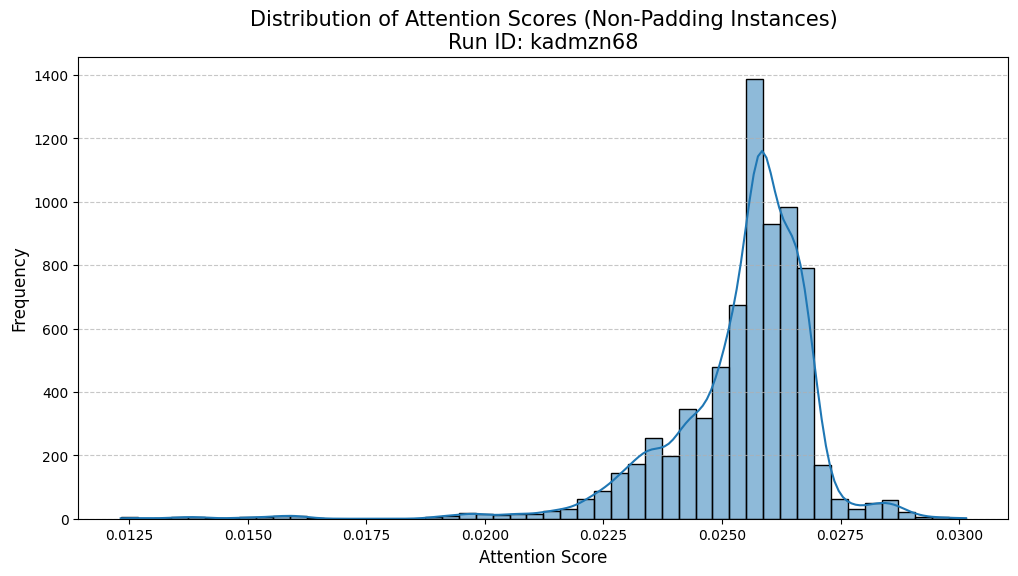

Descriptive statistics for attention scores (Run ID: kadmzn68):
count    7425.000000
mean        0.025401
std         0.001616
min         0.012320
25%         0.024885
50%         0.025766
75%         0.026374
max         0.030146
Name: attention_score, dtype: float64

Visualizing attention scores for instances within 3 sample bag(s) for Run ID: kadmzn68:


/scratch-local/nbraakman.12213673/ipykernel_412340/2756250563.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bag_data['instance_index_in_bag'].astype(str), y=bag_data['attention_score'], palette="viridis")


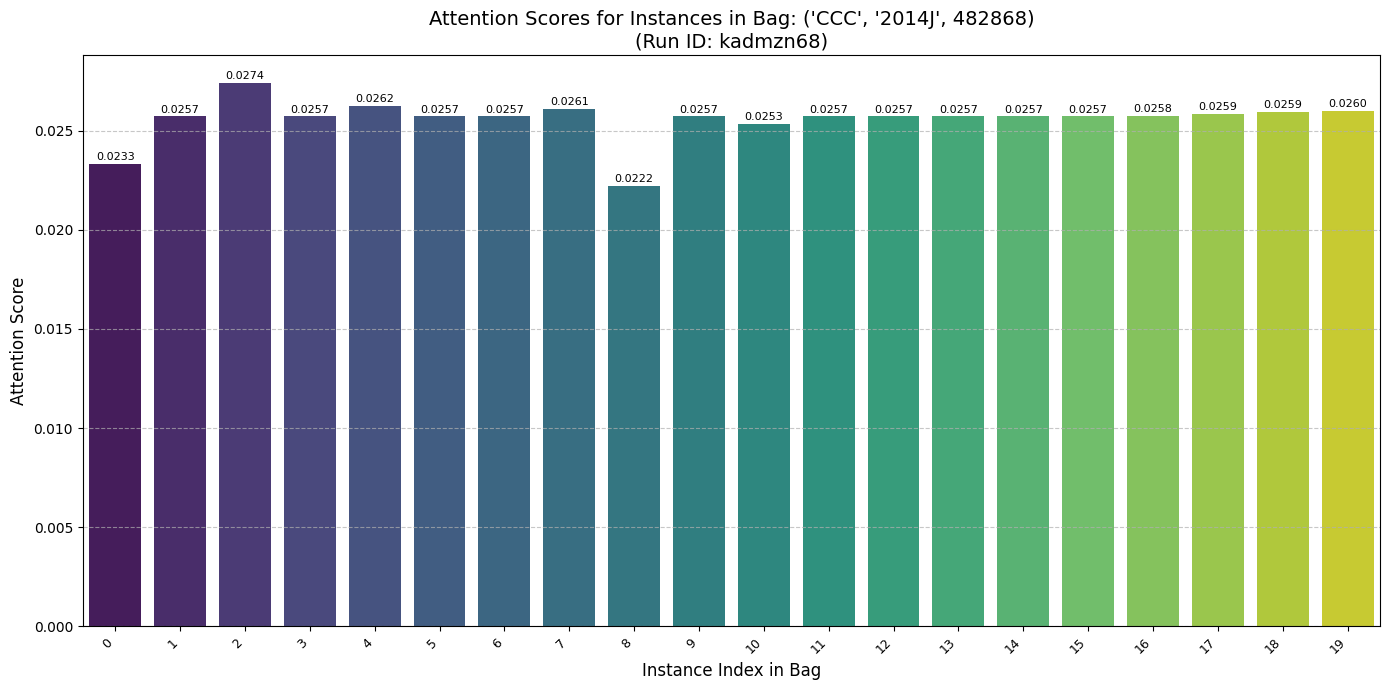

/scratch-local/nbraakman.12213673/ipykernel_412340/2756250563.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bag_data['instance_index_in_bag'].astype(str), y=bag_data['attention_score'], palette="viridis")


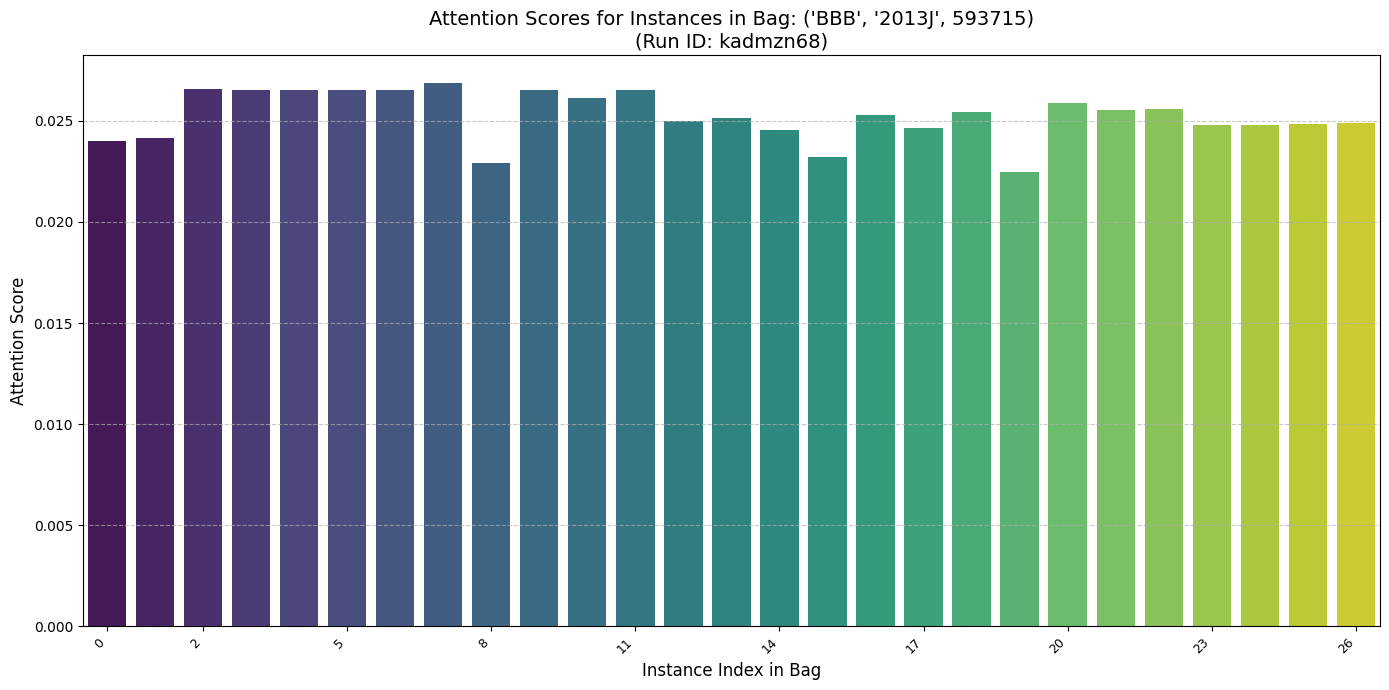

/scratch-local/nbraakman.12213673/ipykernel_412340/2756250563.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bag_data['instance_index_in_bag'].astype(str), y=bag_data['attention_score'], palette="viridis")


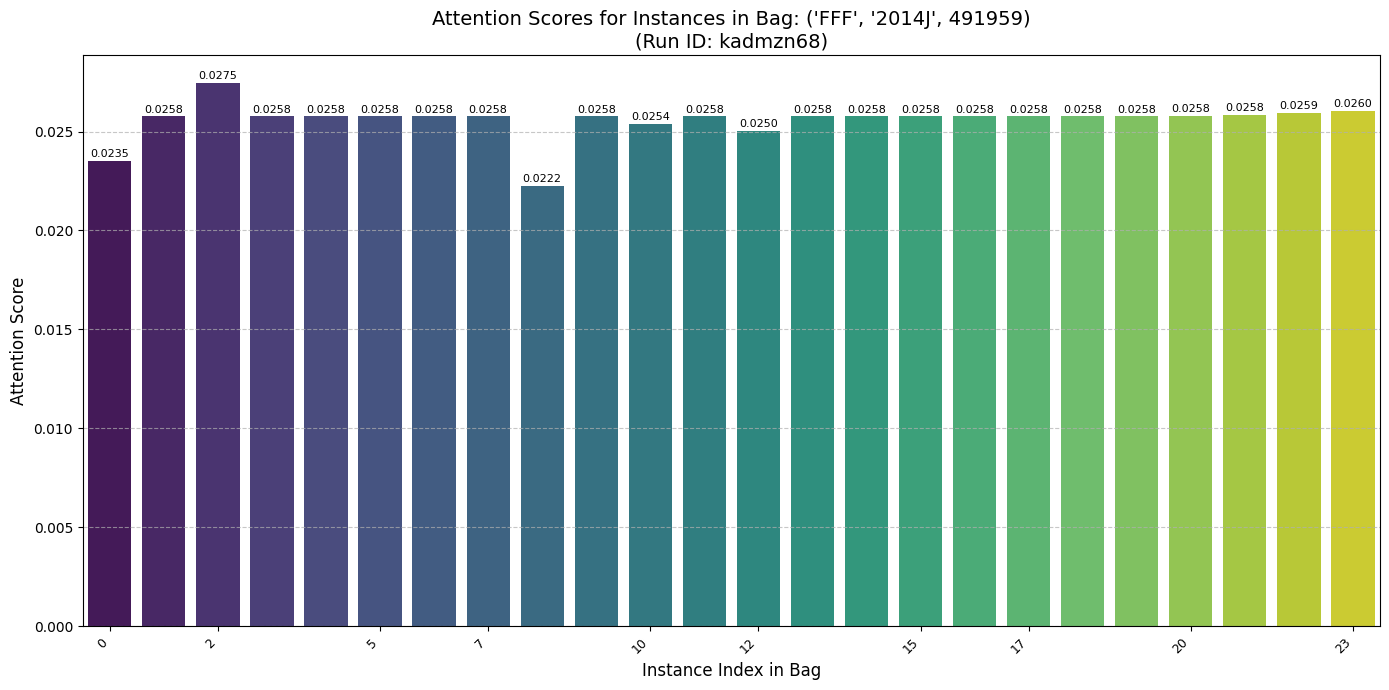

In [10]:
# Ensure df_processed_single_run is available from the previous cell.
# If not, you might need to re-run the cell that defines it or uncomment a load line here.
# For example, if you were starting a new session:
# initial_file_path = os.path.join(DATA_DIR, FILE_PATTERN) # Make sure DATA_DIR and FILE_PATTERN are set
# df_processed_single_run = load_and_preprocess_data(initial_file_path)


# --- Functions for Plotting Attention ---

def plot_attention_distribution(df_processed, run_id_filter=None, plt_show=True):
    """
    Plots the distribution of attention scores from the processed DataFrame.
    Optionally filters by a specific run_id.
    """
    data_to_plot = df_processed
    title_suffix = "All Runs" # Default if no specific run_id is targeted

    # If a run_id_filter is provided, filter the data and update the title
    if run_id_filter and 'run_id' in df_processed.columns:
        data_to_plot = df_processed[df_processed['run_id'] == run_id_filter].copy()
        title_suffix = f"Run ID: {run_id_filter}"
    elif 'run_id' in df_processed.columns and df_processed['run_id'].nunique() == 1:
        # If only one run_id is present in the dataframe, use it for the title
        title_suffix = f"Run ID: {df_processed['run_id'].unique()[0]}"
        
    if data_to_plot.empty or 'attention_score' not in data_to_plot.columns:
        print(f"No data or 'attention_score' column available to plot attention distribution for {title_suffix}.")
        return

    plt.figure(figsize=(12, 6))
    sns.histplot(data_to_plot['attention_score'], kde=True, bins=50)
    plt.title(f'Distribution of Attention Scores (Non-Padding Instances)\n{title_suffix}', fontsize=15)
    plt.xlabel('Attention Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    if plt_show:
        plt.show()
    print(f"Descriptive statistics for attention scores ({title_suffix}):")
    print(data_to_plot['attention_score'].describe())

def plot_attention_per_bag(df_processed, num_sample_bags=3, run_id_filter=None, plt_show=True):
    """
    Plots attention scores for instances within a specified number of sample bags.
    Optionally filters by a specific run_id.
    """
    data_to_plot = df_processed
    base_title_info = "for All Runs"

    # If a run_id_filter is provided, filter the data
    if run_id_filter and 'run_id' in df_processed.columns:
        data_to_plot = df_processed[df_processed['run_id'] == run_id_filter].copy()
        base_title_info = f"for Run ID: {run_id_filter}"
    elif 'run_id' in df_processed.columns and df_processed['run_id'].nunique() == 1:
         base_title_info = f"for Run ID: {df_processed['run_id'].unique()[0]}"

    if 'bag_id' not in data_to_plot.columns or data_to_plot.empty:
        print(f"Cannot plot attention per bag: 'bag_id' column missing or no data {base_title_info}.")
        return

    # Get unique bag_ids from the potentially filtered data
    unique_bag_ids = data_to_plot['bag_id'].unique()
    
    # If num_sample_bags is more than available unique bags, adjust it
    actual_num_sample_bags = min(num_sample_bags, len(unique_bag_ids))
    
    if actual_num_sample_bags == 0:
        print(f"No bag_ids found in the data to visualize {base_title_info}.")
        return
        
    sample_bag_ids = np.random.choice(unique_bag_ids, size=actual_num_sample_bags, replace=False)

    print(f"\nVisualizing attention scores for instances within {len(sample_bag_ids)} sample bag(s) {base_title_info}:")
    for bag_id_to_plot in sample_bag_ids:
        plt.figure(figsize=(14, 7))
        
        # Ensure we are getting data for the specific bag from the (potentially run_id filtered) data_to_plot
        bag_data = data_to_plot[data_to_plot['bag_id'] == bag_id_to_plot].sort_values(by='instance_index_in_bag')
        
        if bag_data.empty:
            print(f"  No data found for bag_id: {bag_id_to_plot} (within {base_title_info})")
            continue
        
        current_run_id_for_plot = bag_data["run_id"].iloc[0] if 'run_id' in bag_data.columns else "N/A"

        ax = sns.barplot(x=bag_data['instance_index_in_bag'].astype(str), y=bag_data['attention_score'], palette="viridis")
        plt.title(f'Attention Scores for Instances in Bag: {bag_id_to_plot}\n(Run ID: {current_run_id_for_plot})', fontsize=14)
        plt.xlabel('Instance Index in Bag', fontsize=12)
        plt.ylabel('Attention Score', fontsize=12)
        
        # Adjust x-ticks for readability
        if len(bag_data['instance_index_in_bag']) > 20: # If many instances, show fewer ticks
            tick_positions = np.linspace(0, len(bag_data['instance_index_in_bag']) - 1, 10, dtype=int)
            tick_labels = bag_data['instance_index_in_bag'].astype(str).iloc[tick_positions]
            plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45, ha='right', fontsize=9)
        else:
            plt.xticks(rotation=45, ha='right', fontsize=9)
            
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Annotate bars with their values if there aren't too many instances in the bag
        if len(bag_data) <= 25: 
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)
        
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        if plt_show:
            plt.show()

# --- Perform Visualizations for the single loaded run ---
if 'df_processed_single_run' in locals() and not df_processed_single_run.empty:
    print(f"\n--- Visualizing Attention for Run: {df_processed_single_run['run_id'].iloc[0]} ---")
    
    # Plot overall attention distribution for this specific run
    plot_attention_distribution(df_processed_single_run, run_id_filter=df_processed_single_run['run_id'].iloc[0])
    
    # Plot attention within a few sample bags for this specific run
    plot_attention_per_bag(df_processed_single_run, num_sample_bags=3, run_id_filter=df_processed_single_run['run_id'].iloc[0])
    
else:
    print("\nVariable 'df_processed_single_run' not found or is empty. Please ensure the previous cell (Cell 2) was run successfully.")



In [13]:
# Ensure df_processed_single_run is available from the previous cells.
# If not, re-run the cells that define and process it.

if 'df_processed_single_run' not in locals() or df_processed_single_run.empty:
    print("DataFrame 'df_processed_single_run' is not available or is empty. Please run previous cells.")
else:
    print(f"--- Analyzing Top-K Selection for First 12 Instances (Run ID: {df_processed_single_run['run_id'].iloc[0]}) ---")

    # --- 1. Define Prediction Outcome Categories ---
    # Create a copy to avoid SettingWithCopyWarning when adding new columns
    df_analysis = df_processed_single_run.copy()

    # Ensure necessary columns for prediction outcome exist
    required_cols = ['true_bag_label', 'predicted_bag_label_ilse', 'was_selected_among_top_k', 'instance_index_in_bag']
    if not all(col in df_analysis.columns for col in required_cols):
        print(f"Error: One or more required columns are missing: {required_cols}. Cannot proceed with this analysis.")
        # Optionally, set df_analysis to an empty DataFrame or handle error appropriately
        # For now, we'll stop this specific analysis if columns are missing.
    else:
        conditions = [
            (df_analysis['true_bag_label'] == 1) & (df_analysis['predicted_bag_label_ilse'] == 1), # True Positive (TP)
            (df_analysis['true_bag_label'] == 0) & (df_analysis['predicted_bag_label_ilse'] == 1), # False Positive (FP)
            (df_analysis['true_bag_label'] == 0) & (df_analysis['predicted_bag_label_ilse'] == 0), # True Negative (TN)
            (df_analysis['true_bag_label'] == 1) & (df_analysis['predicted_bag_label_ilse'] == 0)  # False Negative (FN)
        ]
        outcomes = ['TP', 'FP', 'TN', 'FN']
        df_analysis.loc[:, 'prediction_outcome'] = np.select(conditions, outcomes, default='Unknown')

        # Verify counts of each outcome for context
        print("\nCounts of prediction outcomes for all bags in this run:")
        print(df_analysis.drop_duplicates(subset=['bag_id'])['prediction_outcome'].value_counts())
        
        # --- 2. Filter for the first 12 instances ---
        # These are instances where instance_index_in_bag is 0, 1, ..., 11
        df_first_12_instances = df_analysis[df_analysis['instance_index_in_bag'] < 12].copy()

        if df_first_12_instances.empty:
            print("\nNo instances found with instance_index_in_bag < 12. Cannot create the requested table.")
        else:
            print(f"\nNumber of data points for the first 12 instances: {len(df_first_12_instances)}")
            
            # --- 3. Calculate Top-K Selections ---
            # We want to count how many times 'was_selected_among_top_k' is True
            # Group by 'instance_index_in_bag' and 'prediction_outcome'
            
            # Convert boolean 'was_selected_among_top_k' to int (True=1, False=0) for easy sum
            df_first_12_instances.loc[:, 'top_k_count'] = df_first_12_instances['was_selected_among_top_k'].astype(int)
            
            # Group and sum the 'top_k_count'
            top_k_summary = df_first_12_instances.groupby(['instance_index_in_bag', 'prediction_outcome'])['top_k_count'].sum().reset_index()
            
            # --- 4. Pivot the table for better readability ---
            # Rows: instance_index_in_bag
            # Columns: prediction_outcome
            # Values: top_k_count
            if not top_k_summary.empty:
                top_k_pivot_table = top_k_summary.pivot_table(
                    index='instance_index_in_bag',
                    columns='prediction_outcome',
                    values='top_k_count',
                    fill_value=0 # Fill missing combinations with 0
                ).reindex(columns=outcomes, fill_value=0) # Ensure all outcome columns are present

                print("\nTable: Count of Top-K Selections for First 12 Instances by Prediction Outcome")
                print(top_k_pivot_table)

                # Optional: Add a 'Total_Selected' column
                top_k_pivot_table['Total_Selected_Among_Top_K'] = top_k_pivot_table[outcomes].sum(axis=1)
                print("\nTable with Total Selections:")
                print(top_k_pivot_table)
            else:
                print("\nNo top-k selections found for the first 12 instances to create a pivot table.")



--- Analyzing Top-K Selection for First 12 Instances (Run ID: kadmzn68) ---

Counts of prediction outcomes for all bags in this run:
prediction_outcome
FN    152
TN    110
TP     10
FP      2
Name: count, dtype: int64

Number of data points for the first 12 instances: 3288

Table: Count of Top-K Selections for First 12 Instances by Prediction Outcome
prediction_outcome       TP   FP     TN     FN
instance_index_in_bag                         
0                       0.0  0.0    0.0    0.0
1                       4.0  1.0   33.0   46.0
2                      10.0  2.0  110.0  152.0
3                      10.0  2.0  110.0  152.0
4                       8.0  1.0   83.0  131.0
5                      10.0  2.0  110.0  152.0
6                      10.0  2.0  110.0  152.0
7                      10.0  2.0  110.0  152.0
8                       2.0  2.0   52.0   61.0
9                      10.0  2.0   92.0  137.0
10                     10.0  0.0   13.0   60.0
11                     10.0  2.0  11

--- Generating Feature and Attention Heatmap for Bag ID: ('FFF', '2013J', 577607) (Run ID: kadmzn68) ---


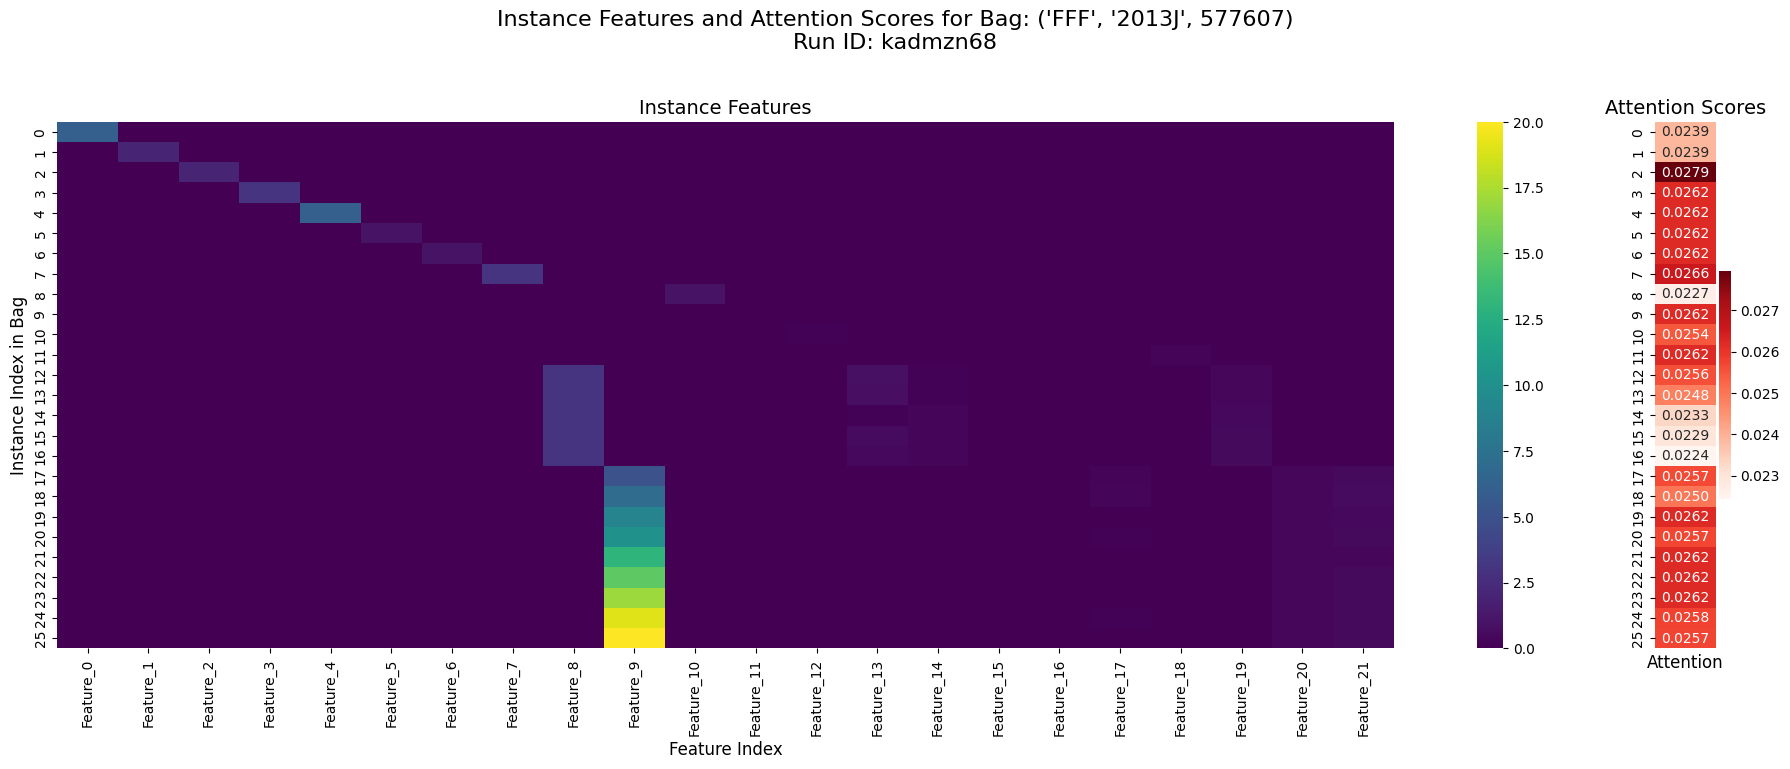

In [14]:
# Ensure df_processed_single_run is available from the previous cells.
# If not, re-run the cells that define and process it.

if 'df_processed_single_run' not in locals() or df_processed_single_run.empty:
    print("DataFrame 'df_processed_single_run' is not available or is empty. Please run previous cells.")
else:
    # --- 1. Select a Sample Bag ---
    # We'll pick the first unique bag_id from the current processed run as an example.
    # You can change this to a specific bag_id string if you want to inspect a particular one.
    available_bag_ids = df_processed_single_run['bag_id'].unique()
    if len(available_bag_ids) == 0:
        print("No bags available in the processed data to generate a heatmap for.")
    else:
        sample_bag_id = available_bag_ids[0] 
        current_run_id = df_processed_single_run['run_id'].iloc[0] # Get the run_id for titling
        print(f"--- Generating Feature and Attention Heatmap for Bag ID: {sample_bag_id} (Run ID: {current_run_id}) ---")

        # --- 2. Filter Data for the Selected Bag ---
        bag_data = df_processed_single_run[df_processed_single_run['bag_id'] == sample_bag_id].sort_values(by='instance_index_in_bag').copy()

        if bag_data.empty:
            print(f"No data found for the selected bag_id: {sample_bag_id}")
        else:
            # --- 3. Prepare Data for Heatmaps ---
            # Attention scores
            attention_scores = bag_data[['attention_score']].values # Reshape for heatmap (n_instances, 1)

            # Instance features from 'parsed_instance_content'
            # Convert list of lists into a 2D NumPy array or DataFrame
            try:
                # Ensure all lists in parsed_instance_content have the same length for this bag
                feature_list = bag_data['parsed_instance_content'].tolist()
                if not feature_list or not all(isinstance(f, list) for f in feature_list):
                     raise ValueError("parsed_instance_content is not a list of lists or is empty.")

                # Check if all feature vectors have the same length
                if feature_list and feature_list[0]:
                    feature_length = len(feature_list[0])
                    if not all(len(f) == feature_length for f in feature_list):
                        print("Warning: Feature vectors in this bag have inconsistent lengths. Heatmap might be misleading or fail.")
                        # Handle inconsistent lengths if necessary (e.g., padding, though ideally they are consistent)
                        # For now, we proceed assuming they will be made consistent or an error will occur if not.
                    
                    feature_matrix = pd.DataFrame(feature_list, index=bag_data['instance_index_in_bag'])
                    num_features = feature_matrix.shape[1]
                    feature_matrix.columns = [f'Feature_{i}' for i in range(num_features)]

                else: # Handles cases where parsed_instance_content might be empty lists
                    print("Warning: 'parsed_instance_content' is empty or not structured as expected for this bag. Cannot create feature heatmap.")
                    feature_matrix = pd.DataFrame() # Empty DataFrame

            except Exception as e:
                print(f"Error preparing feature matrix for heatmap: {e}")
                feature_matrix = pd.DataFrame() # Ensure it's an empty DataFrame on error
            
            # --- 4. Create the Heatmaps ---
            if not feature_matrix.empty:
                fig, axes = plt.subplots(1, 2, figsize=(18, max(6, len(bag_data) * 0.3)), gridspec_kw={'width_ratios': [num_features if num_features > 0 else 1, 1]})
                fig.suptitle(f'Instance Features and Attention Scores for Bag: {sample_bag_id}\nRun ID: {current_run_id}', fontsize=16)

                # Subplot 1: Instance Feature Heatmap
                sns.heatmap(feature_matrix, ax=axes[0], cmap="viridis", cbar=True, annot=False) # Annot can be True if features are interpretable numbers and not too dense
                axes[0].set_title('Instance Features', fontsize=14)
                axes[0].set_xlabel('Feature Index', fontsize=12)
                axes[0].set_ylabel('Instance Index in Bag', fontsize=12)

                # Subplot 2: Attention Score Heatmap (1D)
                sns.heatmap(attention_scores, ax=axes[1], cmap="Reds", cbar=True, annot=True, fmt=".4f", yticklabels=bag_data['instance_index_in_bag'].values)
                axes[1].set_title('Attention Scores', fontsize=14)
                axes[1].set_xlabel('Attention', fontsize=12)
                axes[1].set_ylabel('') # Y-axis label is shared from the first plot implicitly by instance index
                axes[1].set_xticks([]) # No x-ticks needed for a single column heatmap value

                plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
                plt.show()
            
            elif not bag_data.empty and 'attention_score' in bag_data.columns : # Only plot attention if features failed but attention exists
                print("Feature matrix is empty. Plotting only attention scores for the bag.")
                plt.figure(figsize=(4, max(6, len(bag_data) * 0.3)))
                sns.heatmap(attention_scores, cmap="Reds", cbar=True, annot=True, fmt=".4f", yticklabels=bag_data['instance_index_in_bag'].values)
                plt.title(f'Attention Scores for Bag: {sample_bag_id}\nRun ID: {current_run_id}', fontsize=14)
                plt.xlabel('Attention Score', fontsize=12)
                plt.ylabel('Instance Index in Bag', fontsize=12)
                plt.tight_layout()
                plt.show()
            else:
                print("Not enough data to generate heatmaps for this bag.")

